# Fake Jobposting Detection
## Introduction:
This dataset contains 18K job descriptions out of which about 800 are fake.
The data consists of both textual information and meta-information about the jobs.
The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.

Outline:
1. Understand dataset and Feature engineering
  * Data overview report
  * Process categorical features.
  * Represent textual feature as vector.
* Deal with imbalance data
  * Over sampling
* Methods using classical Classifiers.
  * Logistic Regression
  * Random Forest
  * XGBoost
  * Neural Network
* Methods using Bert to interpret text.
  * Bert
  * Albert

In [1]:
# import libraries
import re
import dill

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import matplotlib.gridspec as gridspec

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer

import gensim
from gensim.utils import simple_preprocess

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
# from sklearn import preprocessing, model_selection, pipeline
# from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, roc_auc_score
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# from sklearn.metrics import average_precision_score, precision_recall_curve


from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization

from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

from preprocess_job import reset_ind, cate_to_onehot, tokenizer_wt, remove_stopwords, lemmatization
from ultils import standardize, load_dataset, split_col
from plot_job import plot_cm, plot_aucprc, plotCateColumn
from vectorize import victorize_cbow, victorize_ft, victorize_glove, load_glove, victorize_tfidf


warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2


Using TensorFlow backend.


In [2]:
# read dataset from file
jobPosting, countryCode = load_dataset()
jobPosting.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
# show the extra dataset
countryCode.head()

,Name,Code
0,Afghanistan,AF
1,Åland Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS


## 1. Explore Dataset
The first thing is to have a general feel of the data.
There are 17880 rows with 18 columns of features. 95.15% (17014) of data are real posting, while 4.85% (866) are fake.
The dataset contains three kinds of features: textual, categorical and numerical.
We need to process them individually and select valuable features.

Feature Technicalities:

* **Extra dataset:**
We import a dataset (CountryCode) to help us interpret location information, instead of process it as text.
By transferring location information to Codes, it becomes a categorical column, which is more concise than text.
* **Pandas Profiling:**
We make use of a library to generate data report including value and correlation analysis.
* **Feature augmentation:**
We do three things for : 1. change salary range to three features (salary-low, salary-high, difference); 2. For each
textual columns, calculate its word count as a new feature; 3.  Merge all text into one column (meta_text)
* **Feature selection:**
By analyzing correlation between each column and visualizing data distribution, we selected several important features
to get rid of noise.

### 1.1 Column Types
Generally, there are three kinds of columns:
* Binary columns: All 0/1. They can be used directly.
* Categorical columns: Discrete values. We would explore how to process categories.
* Textual columns: Descriptions with long sentences.
They need to be embedded to vector representation.

We initial these columns name here for further handling.

In [4]:
binary_columns = ["telecommuting", "has_company_logo", "has_questions"]
text_columns = ["title", "company_profile", "description", "requirements", "benefits"]
cate_columns = [ "employment_type", "required_experience", "required_education","industry", "function"]
num_columns = []
label = ["fraudulent"]

### 1.2 Missing value
Since there are quite a lot missing values, we fill them manually instead of dropping them.

In [5]:
# Fill 'None' to NA cell in category
jobPosting[text_columns] = jobPosting[text_columns].fillna(' ')
jobPosting[cate_columns] = jobPosting[cate_columns].fillna("None")
jobPosting.salary_range = jobPosting.salary_range.fillna("0-0")


### 1.3 Feature Augmentation
  * Add word count columns for each textual columns, as well as overall count.

In [6]:
# add word count features for each textual content
jobPosting["overall_count"] = 0
num_columns.append("overall_count")
for col in text_columns:
    count_list = jobPosting[col].str.split(' ').map(lambda x: len(x))
    jobPosting[col + '_count'] = count_list
    jobPosting["overall_count"] += count_list
    num_columns.append(col + '_count')

  * Dived salary to salary_low, salary_high. And calculate salary difference

In [7]:
# Add salary features

# use regular expression to extract lower and upper bound
salary = []
for st in jobPosting.salary_range:
    matches = re.finditer(r'\d+', st)
    salary.append([int(m.group(0)) for m in matches])

# store info in salary_df
salary_df = pd.DataFrame(salary)
salary_df.columns = ["salary_low", "salary_high"]
salary_df["salary_low"][salary_df["salary_high"].isna()] = -1
salary_df["salary_high"][salary_df["salary_high"].isna()] = -1
salary_df["salary_high"] = salary_df["salary_high"].astype(int)
salary_df["salary_diff"] = salary_df["salary_high"] - salary_df["salary_low"]

# merge salary with dataset
jobPosting = jobPosting.join(salary_df)
jobPosting.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,fraudulent,overall_count,title_count,company_profile_count,description_count,requirements_count,benefits_count,salary_low,salary_high,salary_diff
0,1,Marketing Intern,"US, NY, New York",Marketing,0-0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,...,0,384,2,141,124,115,2,0,0,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,0-0,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,0,877,6,150,309,187,225,0,0,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,0-0,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,...,0,356,4,136,50,164,2,0,0,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,0-0,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,...,0,705,5,85,345,174,96,0,0,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,0-0,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,...,0,482,3,205,182,89,3,0,0,0


* Convert location from text to category using extra dataset. Fill NA and exceptions as "Others"

In [8]:
# country code as a new column named country
def process_location(df, column):
    for loc in df[column]:
        code = str(loc)[:str(loc).find(',')]
        if countryCode.Code.isin([code]).any():
            yield code
        else:
            yield "Others"

jobPosting["country"] = list(process_location(jobPosting, "location"))
cate_columns.append('country')

* Generate data report including value and correlation analysis.

In [9]:
# use pandas-profiling to generate report
profile = ProfileReport(jobPosting[cate_columns + binary_columns + num_columns + label], 
                        title='Data Report', 
                        html={'style':{'full_width':True}}
                       )
profile.to_file(output_file="data_report.html")

From the report, we can gain some insights:
1. There are 13.4% duplicate rows, but we should not remove them in order to keep data's original distribution
* 'Industry' and 'country' have high cardinality (around 100)
* From Spearman's Correlation, "company logo" and "profile_count" are very strong features in this case.
* From Phik Correlation (including categories), "country" and "education" are strong features
* We should delete "telecommuting" and "title count"

[Click to view report](./data_report.html)

## 2. Feature  selection
With information above, we would like to select valuable features and get rid of noise.
We can confirm features' relation with fraudulent by plotting distribution.


### 2.1 Numeric features

The plots indicates it is good to keep "overall_count", "company_profile_count".

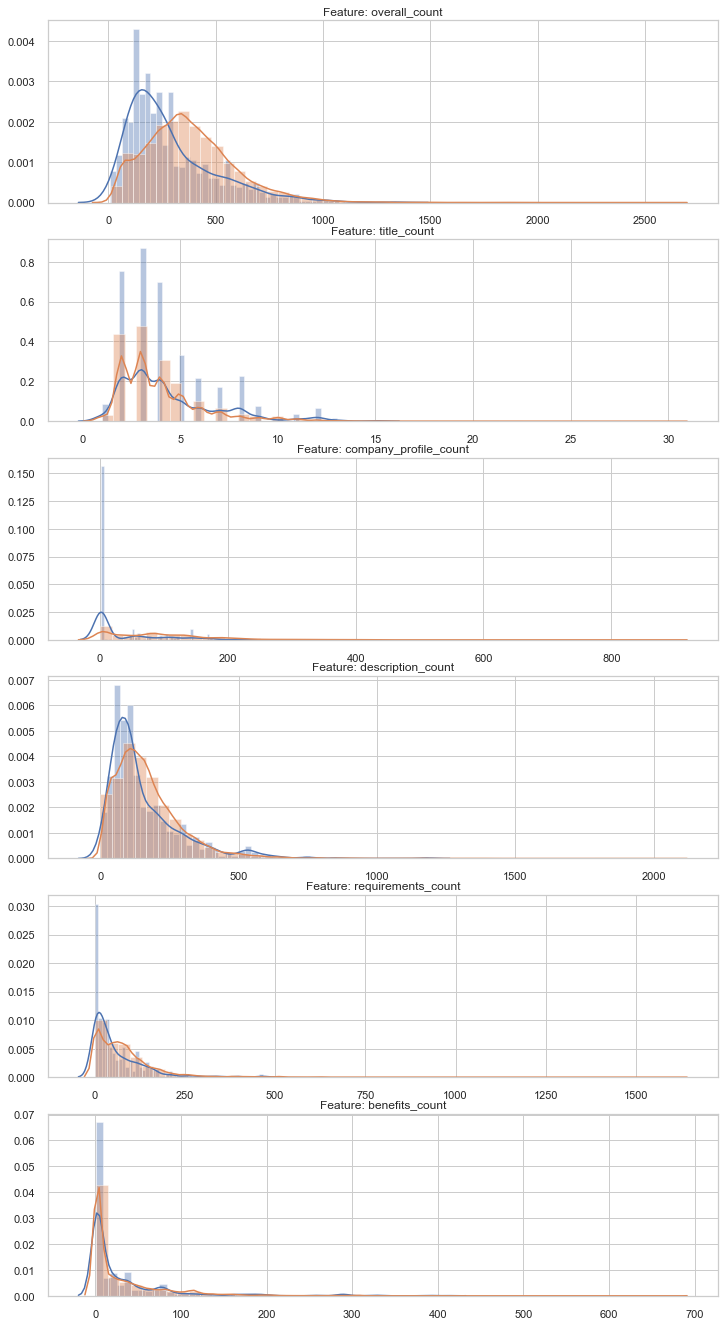

In [10]:
# draw plot for numerical columns
plt.figure(figsize=(12,30*4))
gs = gridspec.GridSpec(30, 1)
for i, feature in enumerate(jobPosting[num_columns]):
    ax = plt.subplot(gs[i])
    sns.distplot(jobPosting[feature][jobPosting.fraudulent == 1], bins=50)
    sns.distplot(jobPosting[feature][jobPosting.fraudulent == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('Feature: ' + str(feature))
plt.show()


* For salary, since salary is highly-skewed, it is better to mute NA values and check distribution.
Maybe it is a magic feature. So we have the log(salary) distribution.
Sadly, the distribution are similar. And we should not include these feature.

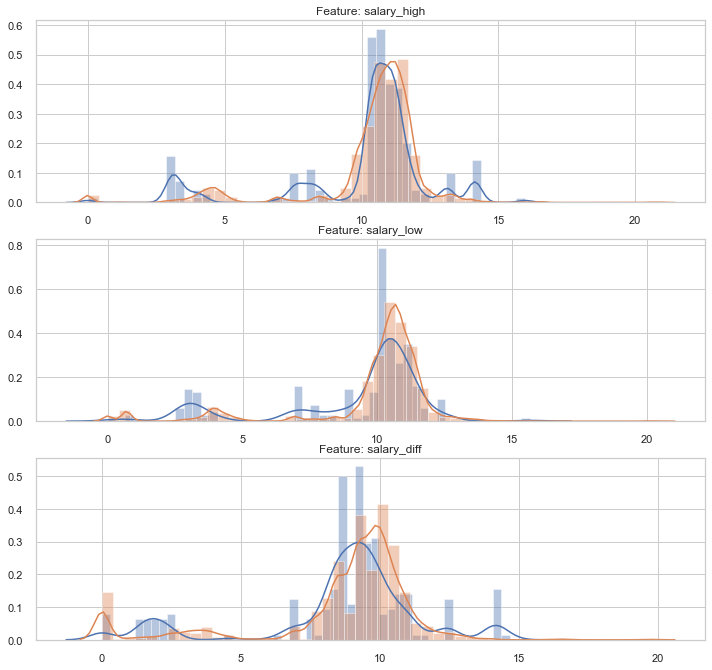

In [11]:
# draw distribution for salary
plt.figure(figsize=(12,30*4))
t = jobPosting[ jobPosting["salary_range"]!="0-0"]
t['salary_low'] = np.log(t['salary_low']+2)
t['salary_high'] = np.log(t['salary_high']+2)
t['salary_diff'] = np.log(t['salary_diff']+1)
gs = gridspec.GridSpec(30, 1)
for i, feature in enumerate(['salary_high', 'salary_low', 'salary_diff']):
    ax = plt.subplot(gs[i])
    sns.distplot(t[feature][t.fraudulent == 1], bins=50)
    sns.distplot(t[feature][t.fraudulent == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('Feature: ' + str(feature))
plt.show()

In [12]:
# fix the num_columns
num_columns = ["overall_count", "company_profile_count"]
binary_columns = ['has_company_logo', 'has_questions']

### 2.2 Categorical columns

We extract the country codes from location as categorical data.
With the help a new dataset named countryCode, we can verify them.
For those unknown codes, they are renamed to "Others".

We not only draw percentage of fraud in each category,
but also, in fraud ratio sorted dataframe, we draw accumulated line for total and fraudulent.
The area between two lines represent the ability of this category.

* Location

Location is a strong feature.
In accumulation plot, fraudulent reach 1.0 at x=18 while total_count just past 0.8.
This can be interpret as: if any data not belong to the top 18 countries, then it is not likely fake.

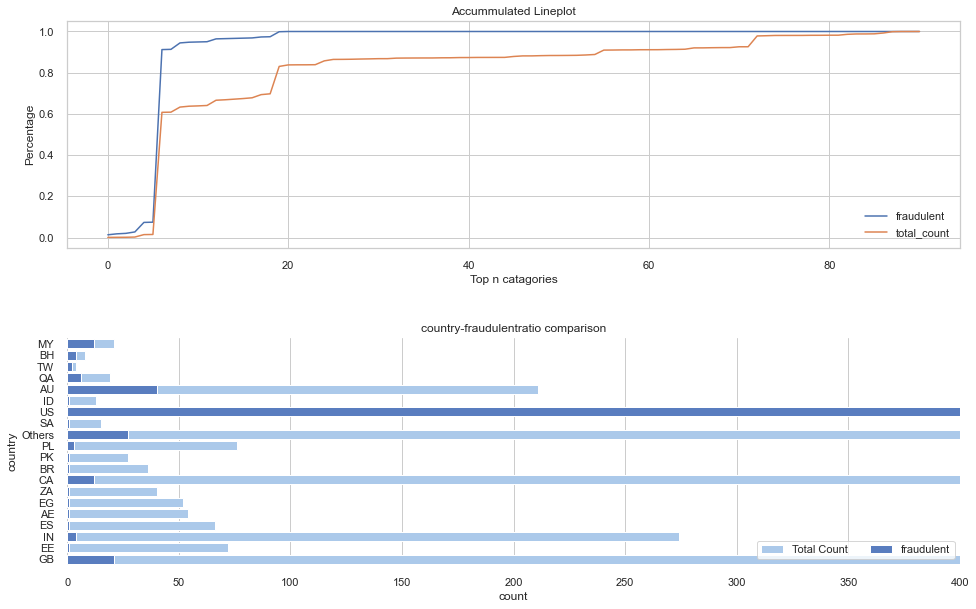

,country,fraudulent,total_count,ratio
55,MY,12,21,0.571429
9,BH,4,8,0.500000
83,TW,2,4,0.500000
68,QA,6,19,0.315789
5,AU,40,211,0.189573
33,ID,1,13,0.076923
86,US,725,10593,0.068441
72,SA,1,15,0.066667
61,Others,27,440,0.061364
66,PL,3,76,0.039474


In [13]:
plotCateColumn(data=jobPosting[cate_columns+label],
               ratio_col="fraudulent",
               group_by="country",
               xlim_bar=(0,400),
               sort_by= 'ratio').head(10)

* Industry

It is a good feature. Same analysis as before: flatulent line reach much early than total_count.

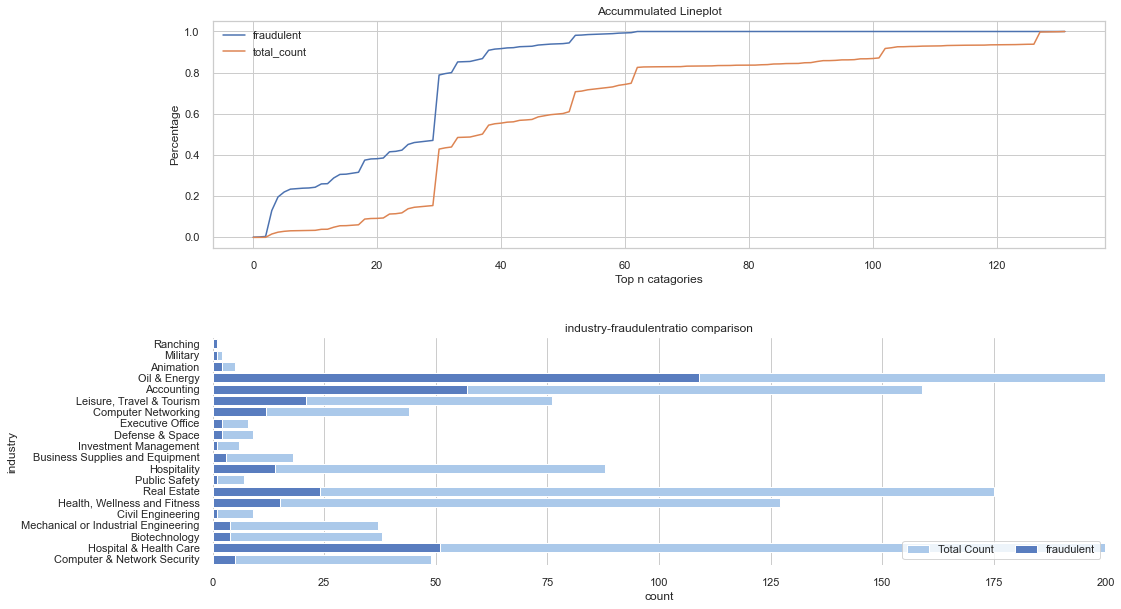

,industry,fraudulent,total_count,ratio
107,Ranching,1,1,1.000000
81,Military,1,2,0.500000
3,Animation,2,5,0.400000
89,Oil & Energy,109,287,0.379791
0,Accounting,57,159,0.358491
67,"Leisure, Travel & Tourism",21,76,0.276316
21,Computer Networking,12,44,0.272727
36,Executive Office,2,8,0.250000
28,Defense & Space,2,9,0.222222
63,Investment Management,1,6,0.166667


In [14]:
plotCateColumn(data=jobPosting[cate_columns+label],
               ratio_col="fraudulent",
               group_by="industry",
               xlim_bar=(0,200),
               sort_by= 'ratio').head(10)

* Function

Same as before. But it is not as strong as Location or Industry.

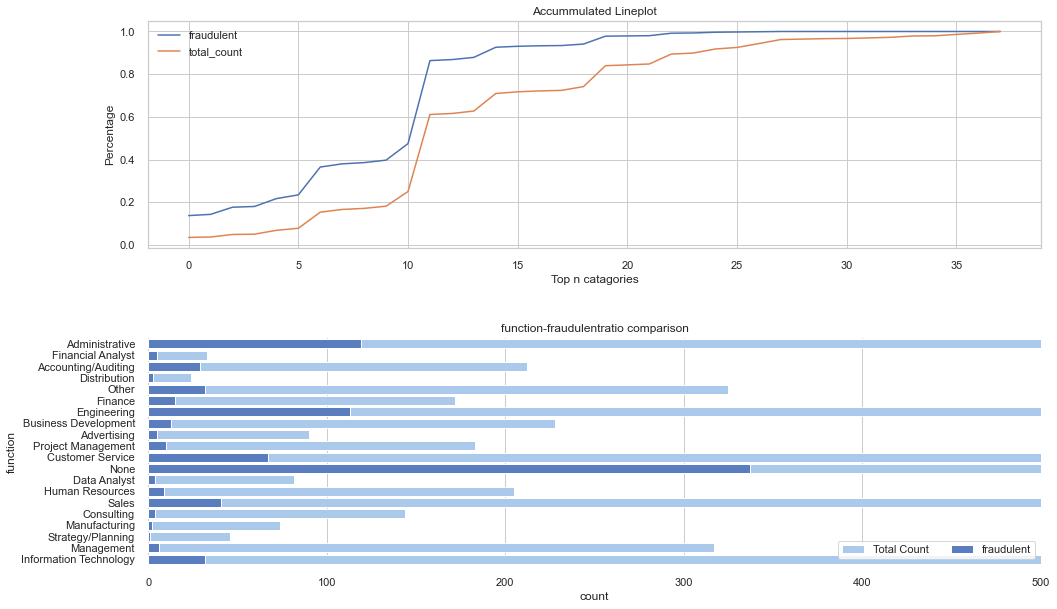

,function,fraudulent,total_count,ratio
1,Administrative,119,630,0.188889
14,Financial Analyst,5,33,0.151515
0,Accounting/Auditing,29,212,0.136792
10,Distribution,3,24,0.125000
24,Other,32,325,0.098462
13,Finance,15,172,0.087209
12,Engineering,113,1348,0.083828
5,Business Development,13,228,0.057018
2,Advertising,5,90,0.055556
27,Project Management,10,183,0.054645


In [15]:
plotCateColumn(data=jobPosting[cate_columns+label],
               ratio_col="fraudulent",
               group_by="function",
               xlim_bar=(0,500),
               sort_by= 'ratio').head(10)

* Employment_type

This is the feature we'd better to mute, since two lines converge nearly at the same time.
Since there is space between two lines in the middle, it is possible to combine with other feature and become magic.
Thus, I choose not to ignore this feature.

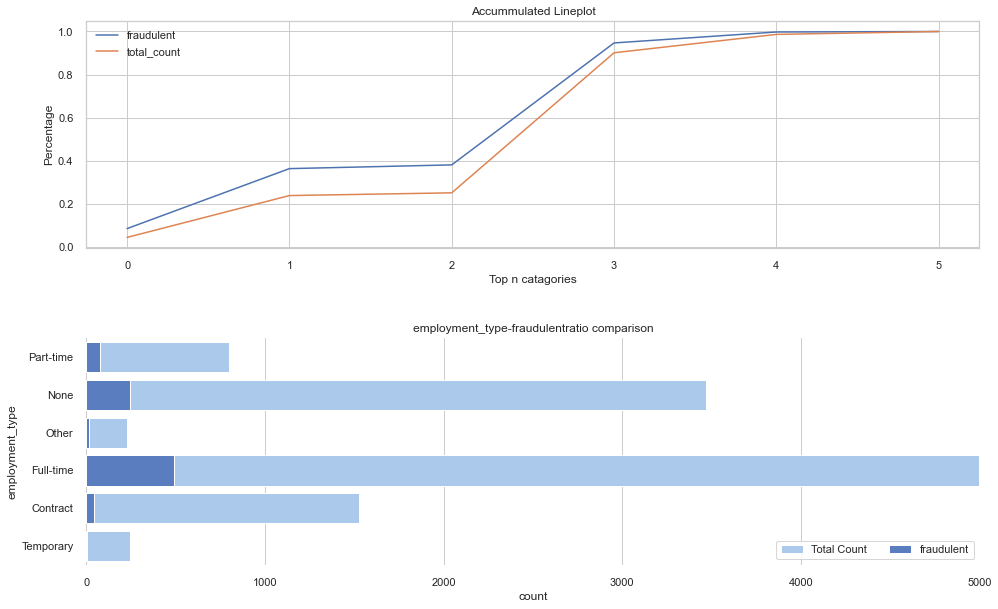

,employment_type,fraudulent,total_count,ratio
4,Part-time,74,797,0.092848
2,None,241,3471,0.069432
3,Other,15,227,0.066079
1,Full-time,490,11620,0.042169
0,Contract,44,1524,0.028871
5,Temporary,2,241,0.008299


In [16]:
plotCateColumn(data=jobPosting[cate_columns+label],
               ratio_col="fraudulent",
               group_by="employment_type",
               xlim_bar=(0,5000),
               sort_by= 'ratio').head(10)

In [17]:
# fix categorical columns
cate_columns = [ "employment_type", "required_experience", "required_education", "industry", "function"]

## 3. Text Processing:
Here we use a function to customize our preprocess.

Feature Technicalities:

* **Tokenizer:**
The module is to grab tokens in document, as well as get rid of punctuation/URL/number/separator etc.
* **Remove stop words:**
Stop means words to support sentence structure like "this", "a" etc.
They are usually unimportant.
* **Lemmatization:**
This step convert words to their root, like apples->apple. I also set PoS tag for filter.

In [ ]:
# set function for preprocessing
def preprocessing(docs):
    docs = list(tokenizer_wt(docs)) # or use tokenizer_sp: simple_process in Gensim
    docs = list(remove_stopwords(docs))
    docs = list(lemmatization(docs))
    return docs

In [19]:
# join textual columns together
jobPosting['meta_text'] = jobPosting[text_columns].apply(
    lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# preprocessing dataset
jobPosting['corpus'] = preprocessing(jobPosting['meta_text'])
jobPosting['corpus'][0]

'marketing intern create award win cooking site support connect celebrate home cook give need place top editorial business engineering team focus use technology find new well way connect people specific food interest offer superb highly curated information food cooking attract talented home cook contributor country also publish well know professional partnership whole food market name good food feature daily techcrunch today show re locate fast grow win online food crowd source curated recipe hub currently interview full part time unpaid intern work small team editor executive headquarter reproduce repackage exist content number partner site buzzfeed various content management systemsresearche blog website provision affiliate programassisting day day affiliate program support screening affiliate assist affiliate pr amp event neededhelpe office administrative work filing mailing prepare meetingsworke developer document bug suggest improvement sitesupporte marketing executive staff exper

## 4. Classifiers Explore
This part shows:
1. how we build the train, valid, test dataset;
2. how to use SMOTE Oversampling for imbalance training set;
3. the results of different models including Logistic Regression, Random Forest, XGBoost, Neural Network.

Feature Technicalities:

* **K-Folds Validation:**
The module is to grab tokens in document, as well as get rid of punctuation/URL/number/separator etc.
* **SMOTE Upsampling:**

* **XGBoost:**


### 4.1 Build datasets
We first split original dataset with stratify methods into 3: training, validation and testing.
And we use training as validation datasets for modeling choosing and parameter tuning.
At last, train model with training+validation, use test set to evaluate results.

Note: Formally, we should use K-Fold Validation and Grid Search to fine tuning parameter.
Due to the time limit, I choose split validation manually, and find parameter according to few experiments.

In [ ]:
# Splitting the dataset into the Training, Valid and Test set
data_df = jobPosting[['corpus'] + num_columns + binary_columns + cate_columns + label]
data_train, data_test = train_test_split(data_df, test_size = 0.2, stratify=data_df[label], random_state = 42)
data_train, data_valid = train_test_split(data_train, test_size = 0.2, stratify=data_train[label], random_state = 42)

# Use data_train to train OneHot Encoder, then use it to represent validation and test categories
data_train, data_valid, data_test = reset_ind(data_train, data_valid, data_test)
data_train, data_valid, data_test = cate_to_onehot(data_train, data_valid, data_test, cate_columns)

                  
print("Shape of training data: ", data_train.shape)
print("Shape of validation data: ", data_valid.shape)
print("Shape of testing data: ", data_test.shape)



In [ ]:
# split data and label
load_glove()
text_col = 'corpus'
embeddings_index = load_glove(path='../../glove/glove.6B.300d.txt', dim=300)

X_train, y_train = split_col(data_train, label)
X_valid, y_valid = split_col(data_valid, label)
X_test, y_test = split_col(data_test, label)




X_train_cbow, X_valid_cbow = victorize_cbow(X_train, X_valid, text_col)
X_train_tfidf, X_valid_tfidf = victorize_tfidf(X_train, X_valid, text_col)
X_train_ft, X_valid_ft = victorize_ft(X_train, X_valid, text_col)
X_train_glove, X_test_glove = victorize_glove(X_train, X_test, text_col, 
                                              embedding=embeddings_index, 
                                              dim=300)
X_train_glove_std, X_test_glove_std = standardize(X_train_glove, X_test_glove, with_mean=False)


X_train_cbow_std, X_valid_cbow_std = standardize(X_train_cbow, X_valid_cbow, with_mean=False)




In [1]:
# dill.dump_session('./env/notebook_env.db')
import dill
dill.load_session('./env/notebook_env.db')

Using TensorFlow backend.


### Logistic Regression


In [ ]:
# predict test use logistic regression


cbow_lr = LogisticRegression(solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
cbow_lr.fit(X_train_cbow_std, np.ravel(y_train))

plot_cm(cbow_lr, X_test_cbow_std, y_test)
plot_aucprc(cbow_lr, X_test_cbow_std, y_test)

## Fasttext representation

In [ ]:
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# auc_buf = []   
# cnt = 0
# predictions = 0
# # enumerate the splits and summarize the distributions

# for train_ind, test_ind in kfold.split(X_train, y_train):
#     print('Fold {}'.format(cnt + 1))
#     X_train_k, X_test_k = X_train.iloc[train_ind, :], X_train.iloc[test_ind, :]
#     y_train_k, y_test_k = y_train.iloc[train_ind, :], y_train.iloc[test_ind, :]
    
#     # Appling Count Vectorizer
#     X_train_k, X_test_k = victorize_ft(X_train_k, X_test_k, 'corpus', training=False)
    
#     lr = LogisticRegression(solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
#     lr.fit(X_train_k, y_train_k)
#     preds = lr.predict(X_test_k)
    
#     auc = roc_auc_score(y_test_k, preds)
#     print('{} AUC: {}'.format(cnt, auc))
#     auc_buf.append(auc)
#     cnt += 1

# print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
# print('AUC std score = {:.6f}'.format(np.std(auc_buf)))

In [ ]:
# fasttext with 100 epoches 300 dim
X_train_ft, X_test_ft = victorize_ft(X_train, X_test, 'corpus', training=False)
X_train_ft_std, X_test_ft_std = standardize(X_train_ft, X_test_ft, with_mean=False)

ft_lr = LogisticRegression(solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
ft_lr.fit(X_train_ft_std, np.ravel(y_train))
plot_cm(ft_lr, X_test_ft_std,y_test)
plot_aucprc(ft_lr, X_test_ft_std, y_test)

## Glove Representation

In [ ]:
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
# auc_buf = []   
# cnt = 0
# predictions = 0
# # enumerate the splits and summarize the distributions
# for train_ind, test_ind in kfold.split(X_train, y_train):
#     print('Fold {}'.format(cnt + 1))
#     X_train_k, X_test_k = X_train.iloc[train_ind, :], X_train.iloc[test_ind, :]
#     y_train_k, y_test_k = y_train.iloc[train_ind, :], y_train.iloc[test_ind, :]
    
#     # Appling Count Vectorizer
    
#     X_train_k, X_test_k = victorize_glove(X_train_k, X_test_k, 'corpus', 
#                                           embedding=embeddings_index)
    
#     lr = LogisticRegression(solver='lbfgs', max_iter=500, verbose=0, n_jobs=-1)
#     lr.fit(X_train_k, y_train_k)
#     preds = lr.predict(X_test_k)
    
#     auc = roc_auc_score(y_test_k, preds)
#     print('{} AUC: {}'.format(cnt, auc))
#     auc_buf.append(auc)
#     cnt += 1

# print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
# print('AUC std score = {:.6f}'.format(np.std(auc_buf)))

In [ ]:
# predict test use logistic regression


glove_lr = LogisticRegression(solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
glove_lr.fit(X_train_glove_std, np.ravel(y_train))

plot_cm(glove_lr, X_test_glove_std, y_test)
plot_aucprc(glove_lr, X_test_glove_std, y_test)

In [ ]:
def get_nn(dim):
    model = Sequential()

    model.add(Dense(256, input_dim=dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# X_train_k, X_test_k
dim = X_train_ft_std.shape[1]
ft_nn = get_nn(dim=dim)
ft_nn.fit(X_train_ft_std, y=y_train, batch_size=64, 
             epochs=10, verbose=0, 
             validation_split=0.1)

plot_cm(ft_nn, X_test_ft_std, y_test)
plot_aucprc(ft_nn, X_test_ft_std, y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
ft_rf = RandomForestClassifier(n_jobs=-1, random_state = 42,
                             n_estimators=500, 
                             min_samples_leaf=2,
                             max_features= 'auto', 
                             criterion = 'entropy')
ft_rf.fit(X_train_ft_std, y_train)

plot_cm(ft_rf, X_test_ft_std, y_test)
plot_aucprc(ft_rf, X_test_ft_std, y_test)


In [ ]:
from xgboost import XGBClassifier
ft_xgb = XGBClassifier(random_state = 42, n_jobs = -1,
                    n_estimators=100, 
                    max_depth=12, 
                    criterion = 'entropy')
ft_xgb.fit(X_train_ft_std_res, y_train_res)

plot_cm(ft_xgb, X_test_ft_std, y_test)
plot_aucprc(ft_xgb, X_test_ft_std, y_test)

In [ ]:
cbow_xgb = XGBClassifier(random_state = 42, n_jobs = -1,
                    n_estimators=100, 
                    max_depth=12, 
                    criterion = 'entropy')
cbow_xgb.fit(X_train_cbow_std, y_train)

plot_cm(cbow_xgb, X_test_cbow_std, y_test)
plot_aucprc(cbow_xgb, X_test_cbow_std, y_test)

In [ ]:


cbow_xgb = XGBClassifier(random_state = 42, n_jobs = -1,
                    n_estimators=100, 
                    max_depth=12, 
                    criterion = 'entropy')
cbow_xgb.fit(X_train_cbow_std_res, y_train_res)

plot_cm(cbow_xgb, X_test_cbow_std, y_test)
plot_aucprc(cbow_xgb, X_test_cbow_std, y_test)


In [ ]:
from bert4keras.models import build_transformer_model
from bert4keras.tokenizers import Tokenizer

config_path = './bert_base/bert_config.json'
checkpoint_path = './bert_base/bert_model.ckpt'
dict_path = './bert_base/vocab.txt'

tokenizer = Tokenizer(dict_path, do_lower_case=True)  # 建立分词器
model = build_transformer_model(config_path, checkpoint_path)  # 建立模型，加载权重

# 编码测试
token_ids, segment_ids = tokenizer.encode(['apple is good', 'he is super good','I do not like his story'])
p = model.predict([np.array([token_ids]), np.array([segment_ids])])
print('\n ===== predicting =====\n')
print(p)
print(p.shape)


# print('\n ===== reloading and predicting =====\n')
# model.save('test.model')
# del model
# model = keras.models.load_model('test.model')
# print(model.predict([np.array([token_ids]), np.array([segment_ids])]))



In [60]:
import numpy as np
from bert4keras.backend import keras, set_gelu
from bert4keras.tokenizers import Tokenizer, SpTokenizer
from bert4keras.models import build_transformer_model
from bert4keras.optimizers import Adam, extend_with_piecewise_linear_lr
from bert4keras.snippets import sequence_padding, DataGenerator
from bert4keras.snippets import open
from keras.layers import Lambda, Dense

set_gelu('tanh')  # 切换gelu版本

num_classes = 2
maxlen = 128
batch_size = 32
config_path = './albert_base_en_tfhub/albert_config.json'
checkpoint_path = './albert_base_en_tfhub/variables/variables'
sentencepiece_model_path = "./albert_base_en_tfhub/assets/30k-clean.model"

col_text = 'corpus'
col_label = 'fraudulent'
def load_data(df, col_text, col_label):
    D = []
    for index, row in df[[col_text, col_label]].iterrows():
        D.append((row[col_text], int(row[col_label])))
    return D




# # 加载数据集
train_data = load_data(data_train, col_text, col_label)
valid_data = load_data(data_valid, col_text, col_label)
test_data = load_data(data_test, col_text, col_label)

# 建立分词器
tokenizer = SpTokenizer(sentencepiece_model_path)

In [61]:
class data_generator(DataGenerator):
    """数据生成器
    """
    def __iter__(self, random=False):
        batch_token_ids, batch_segment_ids, batch_labels = [], [], []
        for is_end, (text, label) in self.sample(random):
            token_ids, segment_ids = tokenizer.encode(text, max_length=maxlen)
            batch_token_ids.append(token_ids)
            batch_segment_ids.append(segment_ids)
            batch_labels.append([label])
            if len(batch_token_ids) == self.batch_size or is_end:
                batch_token_ids = sequence_padding(batch_token_ids)
                batch_segment_ids = sequence_padding(batch_segment_ids)
                batch_labels = sequence_padding(batch_labels)
                yield [batch_token_ids, batch_segment_ids], batch_labels
                batch_token_ids, batch_segment_ids, batch_labels = [], [], []


# 加载预训练模型
bert = build_transformer_model(
    config_path=config_path,
    checkpoint_path=checkpoint_path,
    model='albert',
    return_keras_model=False
)

output = Lambda(lambda x: x[:, 0], name='CLS-token')(bert.model.output)
output = Dense(
    units=num_classes,
    activation='softmax',
    kernel_initializer=bert.initializer
)(output)

model = keras.models.Model(bert.model.input, output)
model.summary()

# 派生为带分段线性学习率的优化器。
AdamLR = extend_with_piecewise_linear_lr(Adam, name='AdamLR')

model.compile(
    loss='sparse_categorical_crossentropy',
    # optimizer=Adam(1e-5),  # 用足够小的学习率
    optimizer=AdamLR(learning_rate=1e-4, lr_schedule={
        1000: 1,
        2000: 0.1
    }),
    metrics=['accuracy'],
)

# 转换数据集
train_generator = data_generator(train_data, batch_size)
valid_generator = data_generator(valid_data, batch_size)
test_generator = data_generator(test_data, batch_size)


def evaluate(data):
    total, right = 0., 0.
    for x_true, y_true in data:
        y_pred = model.predict(x_true).argmax(axis=1)
        y_true = y_true[:, 0]
        total += len(y_true)
        right += (y_true == y_pred).sum()
    return right / total


class Evaluator(keras.callbacks.Callback):
    def __init__(self):
        self.best_val_acc = 0.

    def on_epoch_end(self, epoch, logs=None):
        val_acc = evaluate(valid_generator)
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            model.save_weights('best_model.weights')
        test_acc = evaluate(test_generator)
        print(
            u'val_acc: %.5f, best_val_acc: %.5f, test_acc: %.5f\n' %
            (val_acc, self.best_val_acc, test_acc)
        )


evaluator = Evaluator()
model.fit_generator(
    train_generator.forfit(),
    steps_per_epoch=len(train_generator),
    epochs=10,
    callbacks=[evaluator]
)

model.load_weights('best_model.weights')
print(u'final test acc: %05f\n' % (evaluate(test_generator)))







Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, None)         0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Embedding-Token (Embedding)     (None, None, 128)    3840000     Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, None, 128)    256         Input-Segment[0][0]              
___________________________________________________________________________________________

KeyboardInterrupt: 

In [62]:
token_ids, segment_ids = tokenizer.encode('apple')

print('\n ===== predicting =====\n')
print(bert.predict([np.array([token_ids]), np.array([segment_ids])]))






 ===== predicting =====



AttributeError: 'ALBERT' object has no attribute 'predict'